Trial 0, Loss: 1.0989
Trial 100, Loss: 1.0988
Trial 200, Loss: 1.0405
Trial 300, Loss: 1.0180
Trial 400, Loss: 1.1582
Trial 500, Loss: 1.0821
Trial 600, Loss: 1.0340
Trial 700, Loss: 1.0277
Trial 800, Loss: 1.0273
Trial 900, Loss: 0.7393
Trial 1000, Loss: 0.8615
Trial 1100, Loss: 0.3918
Trial 1200, Loss: 0.5489
Trial 1300, Loss: 0.5801
Trial 1400, Loss: 1.6579
Trial 1500, Loss: 0.0273
Trial 1600, Loss: 0.8747
Trial 1700, Loss: 0.0237
Trial 1800, Loss: 0.5272
Trial 1900, Loss: 0.6870
Total test reward: 2985


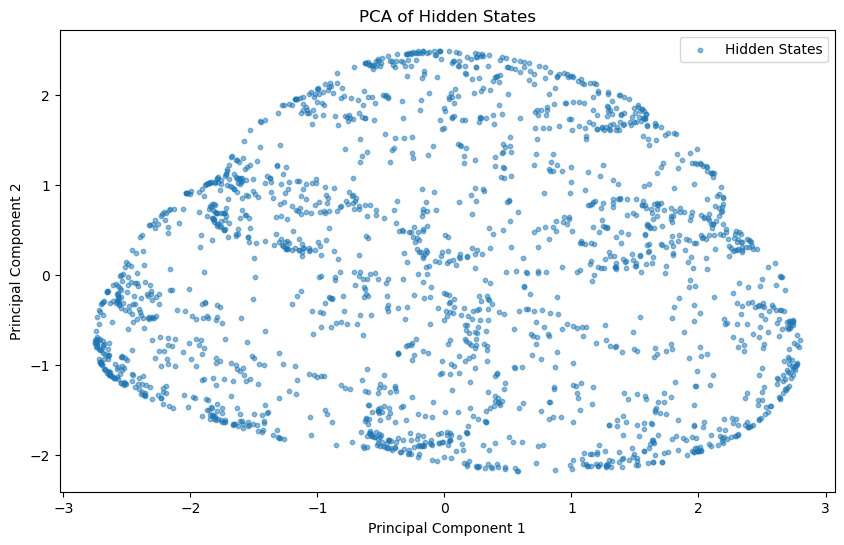

In [20]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class VanillaRNN:
    def __init__(self, n_arms=3, hidden_size=16, learning_rate=0.01):
        self.n_arms = n_arms
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.Wxh = np.random.randn(hidden_size, n_arms) * 0.01  
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01  
        self.Why = np.random.randn(n_arms, hidden_size) * 0.01  
        self.bh = np.zeros((hidden_size, 1))  
        self.by = np.zeros((n_arms, 1))  
    
    def forward(self, x, h_prev):
        h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)
        y = np.dot(self.Why, h) + self.by
        return y, h
    
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
    
    def train(self, n_trials, p, rewards):
        h_prev = np.zeros((self.hidden_size, 1))
        
        for t in range(n_trials):
            choice = np.random.randint(0, self.n_arms)
            x = np.zeros((self.n_arms, 1))
            x[choice] = 1  
            
            y, h_prev = self.forward(x, h_prev)
            probs = self.softmax(y)

            target = np.zeros_like(probs)
            target[choice] = 1 
            loss = -np.sum(target * np.log(probs))
            
            dy = probs - target
            dWhy = np.dot(dy, h_prev.T)
            dby = dy
            dh = np.dot(self.Why.T, dy) * (1 - h_prev ** 2)
            dWxh = np.dot(dh, x.T)
            dWhh = np.dot(dh, h_prev.T)
            dbh = dh
  
            self.Why -= self.learning_rate * dWhy
            self.by -= self.learning_rate * dby
            self.Wxh -= self.learning_rate * dWxh
            self.Whh -= self.learning_rate * dWhh
            self.bh -= self.learning_rate * dbh

            if t % 100 == 0:
                print(f'Trial {t}, Loss: {loss:.4f}')

    def test(self, n_trials, p, rewards):
        h_prev = np.zeros((self.hidden_size, 1))
        total_reward = 0
        
        for t in range(n_trials):
            choice = np.random.randint(0, self.n_arms)
            x = np.zeros((self.n_arms, 1))
            x[choice] = 1

            y, h_prev = self.forward(x, h_prev)
            probs = self.softmax(y)
            selected_arm = np.argmax(probs)

            reward = (np.random.rand() < p[selected_arm]) * rewards[selected_arm]
            total_reward += reward
        
        print(f"Total test reward: {total_reward}")

    def collect_hidden_states(self, n_trials, p, rewards):
        h_prev = np.zeros((self.hidden_size, 1))
        hidden_states = []
        
        for t in range(n_trials):
            choice = np.random.randint(0, self.n_arms)
            x = np.zeros((self.n_arms, 1))
            x[choice] = 1  
            
            _, h_prev = self.forward(x, h_prev)
            hidden_states.append(h_prev.flatten())
        
        return np.array(hidden_states)

n_arms = 3
p = (0.5, 0.7, 0.2)  
rewards = (10, 20, 5)  
n_trials = 2000


model = VanillaRNN(n_arms=n_arms)
model.train(n_trials, p, rewards)


test_trials = 500
model.test(test_trials, p, rewards)

hidden_states = model.collect_hidden_states(n_trials, p, rewards)

pca = PCA(n_components=2)
hidden_states_pca = pca.fit_transform(hidden_states)

plt.figure(figsize=(10, 6))
plt.scatter(hidden_states_pca[:, 0], hidden_states_pca[:, 1], alpha=0.5, s=10, label="Hidden States")
plt.title("PCA of Hidden States")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


Trial 0, Loss: 1.0989
Trial 100, Loss: 1.1481
Trial 200, Loss: 1.1241
Trial 300, Loss: 0.8349
Trial 400, Loss: 1.0700
Trial 500, Loss: 0.3482
Trial 600, Loss: 0.8623
Trial 700, Loss: 0.9376
Trial 800, Loss: 0.3999
Trial 900, Loss: 0.5330
Trial 1000, Loss: 0.5673
Trial 1100, Loss: 0.2664
Trial 1200, Loss: 0.5382
Trial 1300, Loss: 0.4680
Trial 1400, Loss: 0.4950
Trial 1500, Loss: 1.0297
Trial 1600, Loss: 1.0747
Trial 1700, Loss: 0.1328
Trial 1800, Loss: 1.3261
Trial 1900, Loss: 0.6885
Total test reward: 3340


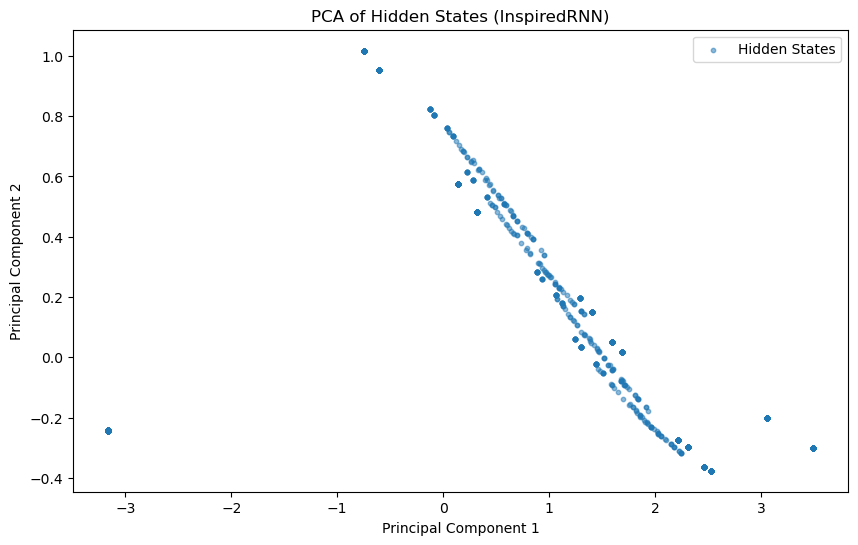

In [15]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class InspiredRNN:
    def __init__(self, n_arms, hidden_size=16, learning_rate=0.01, alpha=0.8):
        self.n_arms = n_arms
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.alpha = alpha  
        self.Wxh = np.random.randn(hidden_size, n_arms) * 0.01  
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01  
        self.Why = np.random.randn(n_arms, hidden_size) * 0.01  
        self.W_stm = np.zeros((hidden_size, n_arms))  
        self.bh = np.zeros((hidden_size, 1))  
        self.by = np.zeros((n_arms, 1))  
    
    def forward(self, x, h_prev):
        h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + np.dot(self.W_stm, x) + self.bh)
        y = np.dot(self.Why, h) + self.by
        return y, h
    
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
    
    def train(self, n_trials, p, rewards):
        h_prev = np.zeros((self.hidden_size, 1))
        
        for t in range(n_trials):
            choice = np.random.randint(0, self.n_arms)
            x = np.zeros((self.n_arms, 1))
            x[choice] = 1  
            
            y, h_prev = self.forward(x, h_prev)
            probs = self.softmax(y)
            
            target = np.zeros_like(probs)
            target[choice] = 1  
            loss = -np.sum(target * np.log(probs))
            
            dy = probs - target
            dWhy = np.dot(dy, h_prev.T)
            dby = dy
            dh = np.dot(self.Why.T, dy) * (1 - h_prev ** 2)
            dWxh = np.dot(dh, x.T)
            dWhh = np.dot(dh, h_prev.T)
            dbh = dh
            
            reward = (np.random.rand() < p[choice]) * rewards[choice]
            self.W_stm = self.alpha * self.W_stm + (1 - self.alpha) * reward * x.T
            
            self.Why -= self.learning_rate * dWhy
            self.by -= self.learning_rate * dby
            self.Wxh -= self.learning_rate * dWxh
            self.Whh -= self.learning_rate * dWhh
            self.bh -= self.learning_rate * dbh
            
            if t % 100 == 0:
                print(f'Trial {t}, Loss: {loss:.4f}')

    def test(self, n_trials, p, rewards):
        h_prev = np.zeros((self.hidden_size, 1))
        total_reward = 0
        
        for t in range(n_trials):
            choice = np.random.randint(0, self.n_arms)
            x = np.zeros((self.n_arms, 1))
            x[choice] = 1
            
            y, h_prev = self.forward(x, h_prev)
            probs = self.softmax(y)
            selected_arm = np.argmax(probs)
            
            reward = (np.random.rand() < p[selected_arm]) * rewards[selected_arm]
            total_reward += reward
        
        print(f"Total test reward: {total_reward}")

    def collect_hidden_states(self, n_trials, p, rewards):
        h_prev = np.zeros((self.hidden_size, 1))
        hidden_states = []
        
        for t in range(n_trials):
            choice = np.random.randint(0, self.n_arms)
            x = np.zeros((self.n_arms, 1))
            x[choice] = 1  
            
            _, h_prev = self.forward(x, h_prev)
            hidden_states.append(h_prev.flatten())
        
        return np.array(hidden_states)


n_arms = 3
p = (0.5, 0.7, 0.2)  
rewards = (10, 20, 5)  
n_trials = 2000

model = InspiredRNN(n_arms)
model.train(n_trials, p, rewards)

test_trials = 500
model.test(test_trials, p, rewards)

hidden_states = model.collect_hidden_states(n_trials, p, rewards)

pca = PCA(n_components=2)
hidden_states_pca = pca.fit_transform(hidden_states)

plt.figure(figsize=(10, 6))
plt.scatter(hidden_states_pca[:, 0], hidden_states_pca[:, 1], alpha=0.5, s=10, label="Hidden States")
plt.title("PCA of Hidden States (InspiredRNN)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


Trial 0, Loss: 1.3921
Trial 100, Loss: 0.6997
Trial 200, Loss: 1.6101
Trial 300, Loss: 1.6987
Trial 400, Loss: 0.7268
Trial 500, Loss: 0.5094
Trial 600, Loss: 0.6157
Trial 700, Loss: 1.0221
Trial 800, Loss: 2.4253
Trial 900, Loss: 0.4784
Total test reward: 1305


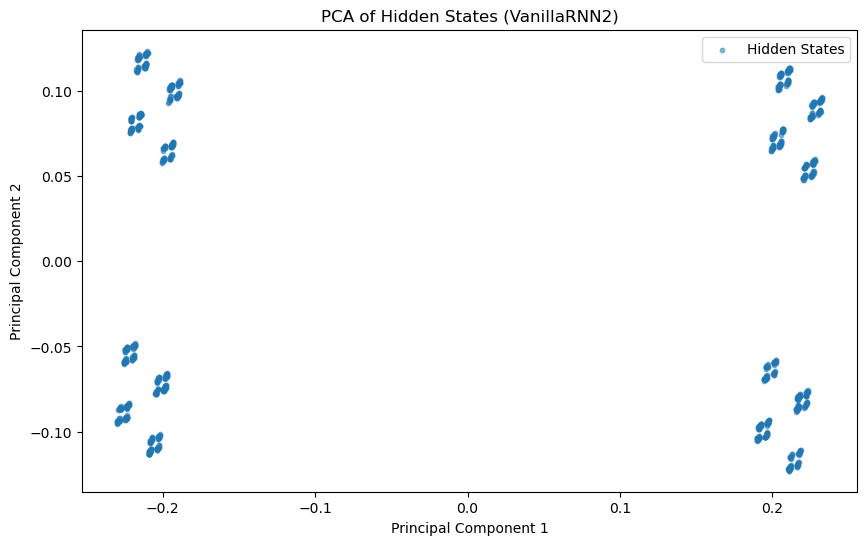

In [34]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class VanillaRNN2:
    def __init__(self, n_first_stage, n_second_stage, hidden_size=16, learning_rate=0.1):
        self.n_first_stage = n_first_stage
        self.n_second_stage = n_second_stage
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.Wxh = np.random.randn(hidden_size, n_first_stage) * 0.1  
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.1  
        self.Why = np.random.randn(n_first_stage, hidden_size) * 0.1  
        self.Wx_stage2 = np.random.randn(hidden_size, n_second_stage) * 0.1  
        self.Why_stage2 = np.random.randn(n_second_stage, hidden_size) * 0.1  
        self.bh = np.zeros((hidden_size, 1)) 
        self.by = np.zeros((n_first_stage, 1))  
        self.by_stage2 = np.zeros((n_second_stage, 1))  

    def forward(self, x, h_prev):
        h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)
        y = np.dot(self.Why, h) + self.by
        return y, h

    def forward_stage2(self, x, h_prev):
        h = np.tanh(np.dot(self.Wx_stage2, x) + np.dot(self.Whh, h_prev) + self.bh)
        y = np.dot(self.Why_stage2, h) + self.by_stage2
        return y, h

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def train(self, n_trials, transition_probs, rewards):
        h_prev = np.zeros((self.hidden_size, 1))
        self.hidden_states = []  

        for t in range(n_trials):
            first_choice = np.random.randint(0, self.n_first_stage)
            x1 = np.zeros((self.n_first_stage, 1))
            x1[first_choice] = 1

            y1, h_prev = self.forward(x1, h_prev)
            probs1 = self.softmax(y1)

            first_selected = np.random.choice(range(self.n_first_stage), p=probs1.ravel())
            stage2_state = np.random.choice(range(self.n_second_stage), p=transition_probs[first_selected])

            x2 = np.zeros((self.n_second_stage, 1))
            x2[stage2_state] = 1

            y2, h_prev = self.forward_stage2(x2, h_prev)
            probs2 = self.softmax(y2)

            second_selected = np.random.choice(range(self.n_second_stage), p=probs2.ravel())
            reward = rewards[stage2_state][second_selected]

            target1 = np.zeros_like(probs1)
            target1[first_selected] = 1
            target2 = np.zeros_like(probs2)
            target2[second_selected] = 1

            loss = -np.sum(target1 * np.log(probs1)) - np.sum(target2 * np.log(probs2))

            dy2 = probs2 - target2
            dWhy_stage2 = np.dot(dy2, h_prev.T)
            dby_stage2 = dy2
            dh2 = np.dot(self.Why_stage2.T, dy2) * (1 - h_prev ** 2)

            dy1 = probs1 - target1
            dWhy = np.dot(dy1, h_prev.T)
            dby = dy1
            dh1 = np.dot(self.Why.T, dy1) * (1 - h_prev ** 2)

            self.Why_stage2 -= self.learning_rate * dWhy_stage2
            self.by_stage2 -= self.learning_rate * dby_stage2
            self.Why -= self.learning_rate * dWhy
            self.by -= self.learning_rate * dby

            self.hidden_states.append(h_prev.flatten())

            if t % 100 == 0:
                print(f'Trial {t}, Loss: {loss:.4f}')

    def test(self, n_trials, transition_probs, rewards):
        h_prev = np.zeros((self.hidden_size, 1))
        total_reward = 0

        for t in range(n_trials):
            x1 = np.random.rand(self.n_first_stage, 1)
            y1, h_prev = self.forward(x1, h_prev)
            probs1 = self.softmax(y1)
            first_selected = np.argmax(probs1)
            stage2_state = np.random.choice(range(self.n_second_stage), p=transition_probs[first_selected])

            x2 = np.random.rand(self.n_second_stage, 1)
            y2, h_prev = self.forward_stage2(x2, h_prev)
            probs2 = self.softmax(y2)
            second_selected = np.argmax(probs2)

            reward = rewards[stage2_state][second_selected]
            total_reward += reward

        print(f"Total test reward: {total_reward}")


n_first_stage = 2
n_second_stage = 2
transition_probs = [[0.7, 0.3], [0.4, 0.6]]  
rewards = [[5, 10], [20, 15]]  
n_trials = 1000

model = VanillaRNN2(n_first_stage, n_second_stage)
model.train(n_trials, transition_probs, rewards)

test_trials = 100
model.test(test_trials, transition_probs, rewards)

hidden_states = np.array(model.hidden_states)
pca = PCA(n_components=2)
hidden_states_pca = pca.fit_transform(hidden_states)

plt.figure(figsize=(10, 6))
plt.scatter(hidden_states_pca[:, 0], hidden_states_pca[:, 1], alpha=0.5, s=10, label="Hidden States")
plt.title("PCA of Hidden States (VanillaRNN2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


Trial 0, Loss: 1.4002
Trial 100, Loss: 0.1785
Trial 200, Loss: 0.2020
Trial 300, Loss: 0.6033
Trial 400, Loss: 0.9364
Trial 500, Loss: 0.2652
Trial 600, Loss: 0.2179
Trial 700, Loss: 2.9149
Trial 800, Loss: 1.9048
Trial 900, Loss: 0.4108
Total test reward: 1295


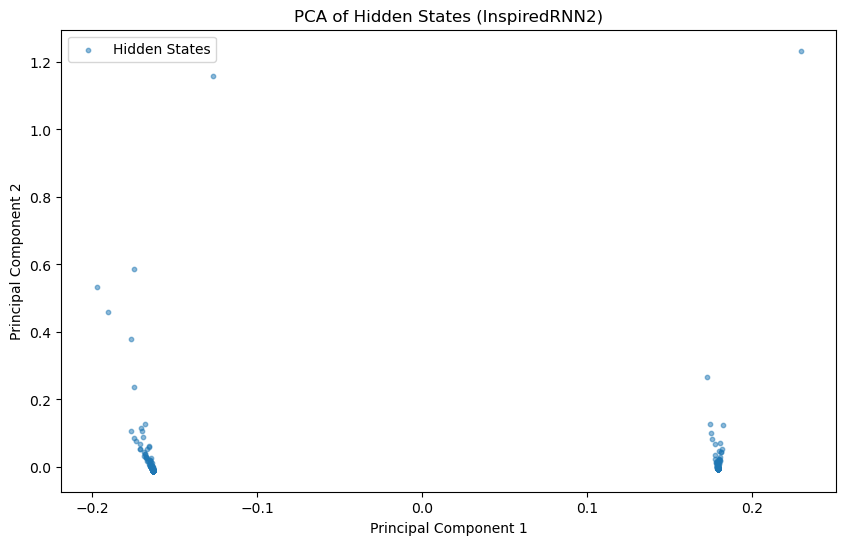

In [32]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class InspiredRNN2:
    def __init__(self, n_first_stage, n_second_stage, hidden_size=16, learning_rate=0.1, alpha=0.8):
        self.n_first_stage = n_first_stage
        self.n_second_stage = n_second_stage
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.alpha = alpha  
        
        self.Wxh = np.random.randn(hidden_size, n_first_stage) * 0.1  
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.1  
        self.Why = np.random.randn(n_first_stage, hidden_size) * 0.1  
        self.W_stm = np.zeros((hidden_size, n_first_stage))  
        self.Wx_stage2 = np.random.randn(hidden_size, n_second_stage) * 0.1  
        self.Why_stage2 = np.random.randn(n_second_stage, hidden_size) * 0.1  
        self.bh = np.zeros((hidden_size, 1))  
        self.by = np.zeros((n_first_stage, 1))  
        self.by_stage2 = np.zeros((n_second_stage, 1))  

    def forward(self, x, h_prev):
        h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + np.dot(self.W_stm, x) + self.bh)
        y = np.dot(self.Why, h) + self.by
        return y, h

    def forward2(self, x, h_prev):
        h = np.tanh(np.dot(self.Wx_stage2, x) + np.dot(self.Whh, h_prev) + self.bh)
        y = np.dot(self.Why_stage2, h) + self.by_stage2
        return y, h

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def train(self, n_trials, transition_probs, rewards):
        h_prev = np.zeros((self.hidden_size, 1))
        self.hidden_states = []  

        for t in range(n_trials):
            first_choice = np.random.randint(0, self.n_first_stage)
            x1 = np.zeros((self.n_first_stage, 1))
            x1[first_choice] = 1

            y1, h_prev = self.forward(x1, h_prev)
            probs1 = self.softmax(y1)
            first_selected = np.random.choice(range(self.n_first_stage), p=probs1.ravel())
            stage2_state = np.random.choice(range(self.n_second_stage), p=transition_probs[first_selected])

            x2 = np.zeros((self.n_second_stage, 1))
            x2[stage2_state] = 1

            y2, h_prev = self.forward2(x2, h_prev)
            probs2 = self.softmax(y2)
            second_selected = np.random.choice(range(self.n_second_stage), p=probs2.ravel())

            reward = rewards[stage2_state][second_selected]

            self.W_stm = self.alpha * self.W_stm + (1 - self.alpha) * reward * x1.T

            target1 = np.zeros_like(probs1)
            target1[first_selected] = 1
            target2 = np.zeros_like(probs2)
            target2[second_selected] = 1
            loss = -np.sum(target1 * np.log(probs1)) - np.sum(target2 * np.log(probs2))

            dy2 = probs2 - target2
            dWhy_stage2 = np.dot(dy2, h_prev.T)
            dby_stage2 = dy2
            dh2 = np.dot(self.Why_stage2.T, dy2) * (1 - h_prev ** 2)

            dy1 = probs1 - target1
            dWhy = np.dot(dy1, h_prev.T)
            dby = dy1
            dh1 = np.dot(self.Why.T, dy1) * (1 - h_prev ** 2)

            self.Why_stage2 -= self.learning_rate * dWhy_stage2
            self.by_stage2 -= self.learning_rate * dby_stage2
            self.Why -= self.learning_rate * dWhy
            self.by -= self.learning_rate * dby

            self.hidden_states.append(h_prev.flatten())

            if t % 100 == 0:
                print(f"Trial {t}, Loss: {loss:.4f}")

    def test(self, n_trials, transition_probs, rewards):
        h_prev = np.zeros((self.hidden_size, 1))
        total_reward = 0

        for t in range(n_trials):
            x1 = np.random.rand(self.n_first_stage, 1)
            y1, h_prev = self.forward(x1, h_prev)
            probs1 = self.softmax(y1)
            first_selected = np.argmax(probs1)
            stage2_state = np.random.choice(range(self.n_second_stage), p=transition_probs[first_selected])

            x2 = np.random.rand(self.n_second_stage, 1)
            y2, h_prev = self.forward2(x2, h_prev)
            probs2 = self.softmax(y2)
            second_selected = np.argmax(probs2)

            reward = rewards[stage2_state][second_selected]
            total_reward += reward

        print(f"Total test reward: {total_reward}")



n_first_stage = 2
n_second_stage = 2
transition_probs = [[0.7, 0.3], [0.4, 0.6]]  
rewards = [[5, 10], [20, 15]]  
n_trials = 1000


model = InspiredRNN2(n_first_stage, n_second_stage)
model.train(n_trials, transition_probs, rewards)

test_trials = 100
model.test(test_trials, transition_probs, rewards)

hidden_states = np.array(model.hidden_states)
pca = PCA(n_components=2)
hidden_states_pca = pca.fit_transform(hidden_states)

plt.figure(figsize=(10, 6))
plt.scatter(hidden_states_pca[:, 0], hidden_states_pca[:, 1], alpha=0.5, s=10, label="Hidden States")
plt.title("PCA of Hidden States (InspiredRNN2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()
